In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


In [9]:
def get_stock_data(stock_name,shift_window, normalized=0):
    from pandas_datareader import data

    # Only get the adjusted close.
    df = data.DataReader(stock_name,
                       start='2017-1-1',
                       end='2018-08-20',
                       data_source='yahoo')

    df['Adj Close future'] = df['Adj Close'].shift(-shift_window)
    #df['Difference'] = ( df['Adj Close'].shift(-shift_window) / df['Adj Close'] ) 
    #df['Difference'] = ( df['Difference'] -1 )
    #print(df.head())
    df['Volume'] /= 100
    return df[:-shift_window]

In [72]:
stock_name = 'TRAN.BA'
df = get_stock_data(stock_name,10,1)




In [73]:
print(df.tail(25))
df_val = df.values
df_val[3]

                 High        Low       Open      Close    Volume  Adj Close  \
Date                                                                          
2018-07-02  40.900002  36.700001  40.900002  38.450001  13008.83  38.450001   
2018-07-03  44.000000  39.500000  39.500000  43.349998  11216.23  43.349998   
2018-07-04  46.299999  42.750000  44.000000  45.849998   3616.27  45.849998   
2018-07-05  48.000000  44.400002  45.900002  46.900002   3152.84  46.900002   
2018-07-06  47.400002  44.049999  46.500000  46.900002   4350.53  46.900002   
2018-07-10  49.049999  47.500000  48.000000  48.549999   4011.10  48.549999   
2018-07-11  48.599998  45.299999  48.599998  46.549999   2142.89  46.549999   
2018-07-12  48.000000  43.500000  46.500000  44.200001   2664.91  44.200001   
2018-07-13  44.700001  42.250000  44.200001  44.150002   3425.94  44.150002   
2018-07-16  44.150002  42.250000  44.150002  43.150002   2154.04  43.150002   
2018-07-17  45.549999  42.250000  43.849998  45.1500

array([  17.79999924,   16.60000038,   17.04999924,   17.54999924,
       4638.35      ,   17.54999924,   16.95000076])

In [74]:
def load_data_NOT_USED(stock, seq_len):

    data = stock
    amount_of_features = len(data[::-1][0]) - 1
    
    
    sequence_length = seq_len 
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length + 1])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    print ("x_test:",x_test)
    y_test = result[int(row):, -1][:,-1]
    print ("y_test:",y_test)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [75]:
def load_data_v2(stock, seq_len):

    data_x = stock
    data_y = stock
    #print("DATA Y 0 :",data_y)
    print ("Amount of features TOT :",len(data_x[0]) )
    data_x = np.delete(data_x,np.s_[len(stock[0])-1],axis=1)
    data_y = np.delete(data_y,np.s_[0:len(stock[0])-1],axis=1)
    #print("DATA Y :",data_y)
    amount_of_features = len(data_x[0]) 
    
    print ("Amount of features found:",amount_of_features)
    
    sequence_length = seq_len 
    result_x = []
    result_y = []
    for index in range(len(data_x) - sequence_length ):
        result_x.append(data_x[index: index + sequence_length + 1])
        result_y.append(data_y[index: index + sequence_length + 1])

    result_x = np.array(result_x)
    result_y = np.array(result_y)
    
    row = round(0.92 * result_x.shape[0])
    train_x = result_x[:int(row), :]
    train_y = result_y[:int(row), :]
    
    x_train = train_x[:, :-1]
    x_test = result_x[int(row):, :-1]
   
    y_train = train_y[:, -1]
    y_test = result_y[int(row):, -1]
    
    #print ("x_test before:",x_test)
    #print ("y_test before:",y_test)
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  
    print ("x_test:",x_test)
    print ("y_test:",y_test)

    return [x_train, y_train, x_test, y_test]

In [76]:
load_data_v2(df_val, 10)

Amount of features TOT : 7
Amount of features found: 6
x_test: [[[   59.95000076    57.25          59.25          58.54999924
    6247.81          58.54999924]
  [   60.70000076    57.65000153    58.70000076    57.90000153
    5164.77          57.90000153]
  [   58.5           55.15000153    57.5           55.45000076
    3301.52          55.45000076]
  ...
  [   47.90000153    45.45000076    45.5           47.09999847
   13498.93          47.09999847]
  [   53.75          50.09999847    51.            53.45000076
   12655.25          53.45000076]
  [   54.            51.75          54.            52.20000076
    1976.21          52.20000076]]

 [[   60.70000076    57.65000153    58.70000076    57.90000153
    5164.77          57.90000153]
  [   58.5           55.15000153    57.5           55.45000076
    3301.52          55.45000076]
  [   55.25          52.5           55.25          53.04999924
    2644.94          53.04999924]
  ...
  [   53.75          50.09999847    51.           

[array([[[   16.39999962,    14.69999981,    15.14999962,    16.20000076,
           4582.86      ,    16.20000076],
         [   16.95000076,    16.20000076,    16.20000076,    16.64999962,
           7303.17      ,    16.64999962],
         [   17.14999962,    16.5       ,    16.60000038,    17.04999924,
           2681.5       ,    17.04999924],
         ...,
         [   16.89999962,    16.        ,    16.89999962,    16.29999924,
          10659.48      ,    16.29999924],
         [   16.29999924,    15.5       ,    16.        ,    16.        ,
           3148.29      ,    16.        ],
         [   17.39999962,    15.69999981,    15.69999981,    17.35000038,
           5197.5       ,    17.35000038]],
 
        [[   16.95000076,    16.20000076,    16.20000076,    16.64999962,
           7303.17      ,    16.64999962],
         [   17.14999962,    16.5       ,    16.60000038,    17.04999924,
           2681.5       ,    17.04999924],
         [   17.79999924,    16.60000038,    17

In [77]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,kernel_initializer='uniform',activation='relu'))        
        model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

In [78]:
len(df_val[0])

7

In [79]:
df_val = df.values / 1000
#for a in range(len(df_val[0])-2):
#    df_val[:,a] /= 1000
window  =  5
X_train, y_train, X_test, y_test = load_data_v2(df_val[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

Amount of features TOT : 7
Amount of features found: 6
x_test: [[[ 0.0212   0.01965  0.0199   0.0209   8.44688  0.0209 ]
  [ 0.02     0.01845  0.0189   0.01995  5.38881  0.01995]
  [ 0.0188   0.0177   0.01835  0.0188   4.26191  0.0188 ]
  [ 0.01855  0.018    0.01855  0.01835  1.30398  0.01835]
  [ 0.01875  0.0182   0.0185   0.0185   3.1078   0.0185 ]]

 [[ 0.02     0.01845  0.0189   0.01995  5.38881  0.01995]
  [ 0.0188   0.0177   0.01835  0.0188   4.26191  0.0188 ]
  [ 0.01855  0.018    0.01855  0.01835  1.30398  0.01835]
  [ 0.01875  0.0182   0.0185   0.0185   3.1078   0.0185 ]
  [ 0.0189   0.018    0.0183   0.01855  4.40248  0.01855]]

 [[ 0.0188   0.0177   0.01835  0.0188   4.26191  0.0188 ]
  [ 0.01855  0.018    0.01855  0.01835  1.30398  0.01835]
  [ 0.01875  0.0182   0.0185   0.0185   3.1078   0.0185 ]
  [ 0.0189   0.018    0.0183   0.01855  4.40248  0.01855]
  [ 0.01815  0.01725  0.01725  0.018    5.51568  0.018  ]]

 [[ 0.01855  0.018    0.01855  0.01835  1.30398  0.01835]
  [

In [80]:
# model = build_model([3,lag,1])
#model = build_model2([3,window,1])
model = build_model2([len(df_val[0])-1,5,1])

model.fit(
    X_train,
    y_train,
    batch_size=576,
    epochs=250,
    validation_split=0.1,
    verbose=1)

Train on 317 samples, validate on 36 samples
Epoch 1/250
317/317 [==============================] - 5s 16ms/step - loss: 0.0019 - acc: 0.0000e+00 - val_loss: 3.1214e-04 - val_acc: 0.0000e+00
Epoch 2/250
317/317 [==============================] - 0s 551us/step - loss: 0.0016 - acc: 0.0000e+00 - val_loss: 1.8728e-04 - val_acc: 0.0000e+00
Epoch 3/250
317/317 [==============================] - 0s 667us/step - loss: 0.0013 - acc: 0.0000e+00 - val_loss: 8.5859e-05 - val_acc: 0.0000e+00
Epoch 4/250
317/317 [==============================] - 0s 565us/step - loss: 9.5748e-04 - acc: 0.0000e+00 - val_loss: 3.2259e-05 - val_acc: 0.0000e+00
Epoch 5/250
317/317 [==============================] - 0s 637us/step - loss: 6.4402e-04 - acc: 0.0000e+00 - val_loss: 6.6251e-05 - val_acc: 0.0000e+00
Epoch 6/250
317/317 [==============================] - 0s 563us/step - loss: 3.8478e-04 - acc: 0.0000e+00 - val_loss: 2.1981e-04 - val_acc: 0.0000e+00
Epoch 7/250
317/317 [==============================] - 0s 613u

Epoch 55/250
317/317 [==============================] - 0s 510us/step - loss: 1.5315e-04 - acc: 0.0000e+00 - val_loss: 4.5221e-04 - val_acc: 0.0000e+00
Epoch 56/250
317/317 [==============================] - 0s 522us/step - loss: 1.5030e-04 - acc: 0.0000e+00 - val_loss: 4.5096e-04 - val_acc: 0.0000e+00
Epoch 57/250
317/317 [==============================] - 0s 492us/step - loss: 1.5565e-04 - acc: 0.0000e+00 - val_loss: 4.4613e-04 - val_acc: 0.0000e+00
Epoch 58/250
317/317 [==============================] - 0s 487us/step - loss: 1.4998e-04 - acc: 0.0000e+00 - val_loss: 4.3880e-04 - val_acc: 0.0000e+00
Epoch 59/250
317/317 [==============================] - 0s 503us/step - loss: 1.5009e-04 - acc: 0.0000e+00 - val_loss: 4.3020e-04 - val_acc: 0.0000e+00
Epoch 60/250
317/317 [==============================] - 0s 486us/step - loss: 1.5083e-04 - acc: 0.0000e+00 - val_loss: 4.2029e-04 - val_acc: 0.0000e+00
Epoch 61/250
317/317 [==============================] - 0s 503us/step - loss: 1.4660e-04

Epoch 109/250
317/317 [==============================] - 0s 478us/step - loss: 1.4162e-04 - acc: 0.0000e+00 - val_loss: 4.0556e-04 - val_acc: 0.0000e+00
Epoch 110/250
317/317 [==============================] - 0s 483us/step - loss: 1.4407e-04 - acc: 0.0000e+00 - val_loss: 4.0558e-04 - val_acc: 0.0000e+00
Epoch 111/250
317/317 [==============================] - 0s 502us/step - loss: 1.3669e-04 - acc: 0.0000e+00 - val_loss: 4.0557e-04 - val_acc: 0.0000e+00
Epoch 112/250
317/317 [==============================] - 0s 492us/step - loss: 1.4285e-04 - acc: 0.0000e+00 - val_loss: 4.0513e-04 - val_acc: 0.0000e+00
Epoch 113/250
317/317 [==============================] - 0s 498us/step - loss: 1.4435e-04 - acc: 0.0000e+00 - val_loss: 4.0467e-04 - val_acc: 0.0000e+00
Epoch 114/250
317/317 [==============================] - 0s 475us/step - loss: 1.4279e-04 - acc: 0.0000e+00 - val_loss: 4.0430e-04 - val_acc: 0.0000e+00
Epoch 115/250
317/317 [==============================] - 0s 486us/step - loss: 1.4

Epoch 163/250
317/317 [==============================] - 0s 471us/step - loss: 1.3894e-04 - acc: 0.0000e+00 - val_loss: 3.9431e-04 - val_acc: 0.0000e+00
Epoch 164/250
317/317 [==============================] - 0s 515us/step - loss: 1.3757e-04 - acc: 0.0000e+00 - val_loss: 3.9650e-04 - val_acc: 0.0000e+00
Epoch 165/250
317/317 [==============================] - 0s 494us/step - loss: 1.4116e-04 - acc: 0.0000e+00 - val_loss: 3.9980e-04 - val_acc: 0.0000e+00
Epoch 166/250
317/317 [==============================] - 0s 501us/step - loss: 1.4135e-04 - acc: 0.0000e+00 - val_loss: 4.0426e-04 - val_acc: 0.0000e+00
Epoch 167/250
317/317 [==============================] - 0s 506us/step - loss: 1.3821e-04 - acc: 0.0000e+00 - val_loss: 4.0837e-04 - val_acc: 0.0000e+00
Epoch 168/250
317/317 [==============================] - 0s 529us/step - loss: 1.3771e-04 - acc: 0.0000e+00 - val_loss: 4.1210e-04 - val_acc: 0.0000e+00
Epoch 169/250
317/317 [==============================] - 0s 482us/step - loss: 1.4

Epoch 217/250
317/317 [==============================] - 0s 499us/step - loss: 1.3410e-04 - acc: 0.0000e+00 - val_loss: 3.8410e-04 - val_acc: 0.0000e+00
Epoch 218/250
317/317 [==============================] - 0s 495us/step - loss: 1.3004e-04 - acc: 0.0000e+00 - val_loss: 3.7831e-04 - val_acc: 0.0000e+00
Epoch 219/250
317/317 [==============================] - 0s 518us/step - loss: 1.3205e-04 - acc: 0.0000e+00 - val_loss: 3.7289e-04 - val_acc: 0.0000e+00
Epoch 220/250
317/317 [==============================] - 0s 506us/step - loss: 1.3280e-04 - acc: 0.0000e+00 - val_loss: 3.7413e-04 - val_acc: 0.0000e+00
Epoch 221/250
317/317 [==============================] - 0s 507us/step - loss: 1.3411e-04 - acc: 0.0000e+00 - val_loss: 3.7927e-04 - val_acc: 0.0000e+00
Epoch 222/250
317/317 [==============================] - 0s 504us/step - loss: 1.3079e-04 - acc: 0.0000e+00 - val_loss: 3.8983e-04 - val_acc: 0.0000e+00
Epoch 223/250
317/317 [==============================] - 0s 466us/step - loss: 1.3

In [81]:
trainScore = model.evaluate(X_train, y_train, verbose=1)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

print (X_test)

testScore = model.evaluate(X_test, y_test, verbose=1)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

353/353 [==============================] - 0s 408us/step
Train Score: 0.00 MSE (0.01 RMSE)
[[[ 0.0212   0.01965  0.0199   0.0209   8.44688  0.0209 ]
  [ 0.02     0.01845  0.0189   0.01995  5.38881  0.01995]
  [ 0.0188   0.0177   0.01835  0.0188   4.26191  0.0188 ]
  [ 0.01855  0.018    0.01855  0.01835  1.30398  0.01835]
  [ 0.01875  0.0182   0.0185   0.0185   3.1078   0.0185 ]]

 [[ 0.02     0.01845  0.0189   0.01995  5.38881  0.01995]
  [ 0.0188   0.0177   0.01835  0.0188   4.26191  0.0188 ]
  [ 0.01855  0.018    0.01855  0.01835  1.30398  0.01835]
  [ 0.01875  0.0182   0.0185   0.0185   3.1078   0.0185 ]
  [ 0.0189   0.018    0.0183   0.01855  4.40248  0.01855]]

 [[ 0.0188   0.0177   0.01835  0.0188   4.26191  0.0188 ]
  [ 0.01855  0.018    0.01855  0.01835  1.30398  0.01835]
  [ 0.01875  0.0182   0.0185   0.0185   3.1078   0.0185 ]
  [ 0.0189   0.018    0.0183   0.01855  4.40248  0.01855]
  [ 0.01815  0.01725  0.01725  0.018    5.51568  0.018  ]]

 [[ 0.01855  0.018    0.01855  0.

Test Score: 0.00 MSE (0.02 RMSE)


In [82]:
print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
print ("pred",p)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

[[0.0175  0.017   0.01745 0.0172  3.12659 0.0172 ]
 [0.018   0.0169  0.018   0.01745 6.2795  0.01745]
 [0.0178  0.0166  0.01705 0.01755 4.63835 0.01755]
 [0.01715 0.0165  0.0166  0.01705 2.6815  0.01705]
 [0.01695 0.0162  0.0162  0.01665 7.30317 0.01665]]
pred [[0.03976408]
 [0.03923462]
 [0.03967093]
 [0.04005292]
 [0.03981559]
 [0.039391  ]
 [0.03903204]
 [0.03883038]
 [0.03907786]
 [0.03992631]
 [0.04064935]
 [0.04048742]
 [0.03984754]
 [0.0394046 ]
 [0.03907932]
 [0.03946433]
 [0.03951492]
 [0.0391998 ]
 [0.03919501]
 [0.03896379]
 [0.03931542]
 [0.0393906 ]
 [0.03940313]
 [0.03933317]
 [0.0407383 ]
 [0.04127611]
 [0.04107039]
 [0.04125914]
 [0.04151941]
 [0.03955634]
 [0.040068  ]]


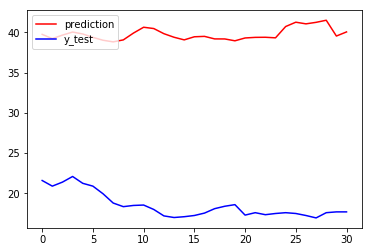

In [83]:
import matplotlib.pyplot as plt2

plt2.plot((p * 1000 ) ,color='red', label='prediction')
plt2.plot(y_test * 1000,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()

In [84]:
def load_data_last(stock_name ):
    from pandas_datareader import data

    # Only get the adjusted close.
    df = data.DataReader(stock_name,
                       start='2017-01-01',
                       end='2018-09-21',
                       data_source='yahoo')

    df['Volume'] /= 100

    df = df[-30:-1]

    
    return df.values

In [85]:
def load_data_prediction(stock, seq_len):

    data_x = stock
    data_y = stock
    #print("DATA Y 0 :",data_y)
    print ("Amount of features TOT :",len(data_x[0]) )
    #data_x = np.delete(data_x,np.s_[len(stock[0])-1],axis=1)
    data_y = np.delete(data_y,np.s_[0:len(stock[0])-1],axis=1)
    #print("DATA Y :",data_y)
    amount_of_features = len(data_x[0]) 
    
    print ("Amount of features found:",amount_of_features)
    
    sequence_length = seq_len 
    result_x = []
    result_y = []
    for index in range(len(data_x) - sequence_length ):
        result_x.append(data_x[index: index + sequence_length + 1])
        result_y.append(data_y[index: index + sequence_length + 1])

    result_x = np.array(result_x)
    result_y = np.array(result_y)
    
    #x_train = train_x[:, :-1]
    x_test = result_x[:, :-1]
    #x_test = result_x[:, :-1]
   
    #y_train = train_y[:, -1]
    y_test = result_y[:, -1]
    
    #print ("x_test before:",x_test)
    #print ("y_test before:",y_test)
    
    #x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  
    print ("x_test:",x_test)
    print ("y_test:",y_test)

    return [x_test, y_test]

In [90]:
df_new2 = load_data_last ('TRAN.BA' )




In [91]:
X_test_future, y_test_future = load_data_prediction(df_new2 / 1000, 5)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

#print(df_new2)

Amount of features TOT : 6
Amount of features found: 6
x_test: [[[ 0.04665  0.0435   0.0455   0.0466   4.31157  0.0466 ]
  [ 0.0456   0.0427   0.045    0.0437   4.34113  0.0437 ]
  [ 0.0464   0.044    0.044    0.04535  2.97752  0.04535]
  [ 0.047    0.043    0.0449   0.0462   1.87038  0.0462 ]
  [ 0.0481   0.04625  0.0463   0.04735  2.95647  0.04735]]

 [[ 0.0456   0.0427   0.045    0.0437   4.34113  0.0437 ]
  [ 0.0464   0.044    0.044    0.04535  2.97752  0.04535]
  [ 0.047    0.043    0.0449   0.0462   1.87038  0.0462 ]
  [ 0.0481   0.04625  0.0463   0.04735  2.95647  0.04735]
  [ 0.04735  0.0455   0.04735  0.0459   1.95428  0.0459 ]]

 [[ 0.0464   0.044    0.044    0.04535  2.97752  0.04535]
  [ 0.047    0.043    0.0449   0.0462   1.87038  0.0462 ]
  [ 0.0481   0.04625  0.0463   0.04735  2.95647  0.04735]
  [ 0.04735  0.0455   0.04735  0.0459   1.95428  0.0459 ]
  [ 0.04795  0.04365  0.047    0.044    5.28106  0.044  ]]

 [[ 0.047    0.043    0.0449   0.0462   1.87038  0.0462 ]
  [

In [92]:
print(X_test[-1])
diff=[]
ratio=[]
pred = model.predict(X_test_future) 
print(pred * 1000)

[[0.0175  0.017   0.01745 0.0172  3.12659 0.0172 ]
 [0.018   0.0169  0.018   0.01745 6.2795  0.01745]
 [0.0178  0.0166  0.01705 0.01755 4.63835 0.01755]
 [0.01715 0.0165  0.0166  0.01705 2.6815  0.01705]
 [0.01695 0.0162  0.0162  0.01665 7.30317 0.01665]]
[[41.71251 ]
 [41.73867 ]
 [42.319824]
 [42.49669 ]
 [42.771164]
 [43.167076]
 [42.919952]
 [43.109478]
 [42.66053 ]
 [43.445156]
 [47.98227 ]
 [50.20374 ]
 [51.390484]
 [51.22215 ]
 [50.510406]
 [45.275436]
 [45.207596]
 [44.882664]
 [44.5483  ]
 [43.97974 ]
 [42.63468 ]
 [42.667984]
 [42.788185]
 [43.966393]]


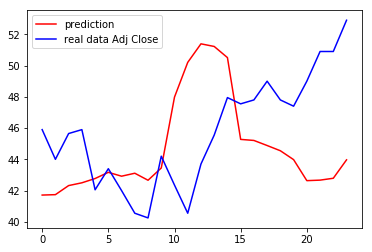

In [93]:
import matplotlib.pyplot as plt2

plt2.plot((pred * 1000 ) ,color='red', label='prediction')
plt2.plot(y_test_future * 1000,color='blue', label='real data Adj Close')
plt2.legend(loc='upper left')
plt2.show()